# Anime Recommedation Project

In [203]:
#Importing all the libraries I'll be using for this notebook

import pandas as pd
pd.set_option('display.max_columns',50)
import re
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from IPython.display import clear_output

### Data Cleanup

In [204]:
#Importing dataset of all anime titles  into a Dataframe
anime_df_no_syn = pd.read_csv('./Anime_data/anime.csv')

In [205]:
anime_df_no_syn.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [206]:
#Checking for any null values
anime_df_no_syn.isna().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [207]:
#Checking the DTypes of all columns in the dataframe
anime_df_no_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [208]:
#Checking for any extreme values
anime_df_no_syn.describe()

,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


### Creating a column for Cleaned names

To have a name for every show in the dataframe, I created a new column called Cleaned_Name, using a list comprehension, to iterate through the English name column and use that value unless the value is 'Unknown", then it uses the the value in the Name column and if that value is 'Unknown' as well, it would use the value in the Japanese name column.

In [209]:
anime_df_no_syn['Cleaned_Name'] = [anime_df_no_syn['English name'][x] if anime_df_no_syn['English name'][x] != 'Unknown' 
                else (anime_df_no_syn['Name'][x] if anime_df_no_syn['Name'][x] != 'Unknown'
                else anime_df_no_syn['Japanese name']) for x in range(len(anime_df_no_syn['English name']))]

In [210]:
anime_df_no_syn[['Name', 'English name', 'Japanese name', 'Cleaned_Name']].head()

,Name,English name,Japanese name,Cleaned_Name
0,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,Cowboy Bebop
1,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Cowboy Bebop:The Movie
2,Trigun,Trigun,トライガン,Trigun
3,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),Witch Hunter Robin
4,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,Beet the Vandel Buster


### Creating Year_Premiered column

In [211]:
#Testing a regex pattern to select years in Aired column
pattern = '\d{4}'
re.findall(pattern, anime_df_no_syn['Aired'][0])

['1998', '1999']

In [212]:
#Using regex in a list comprehension to select only the years in Aired column
anime_df_no_syn['Year_Premiered'] = [re.findall(pattern, anime_df_no_syn['Aired'][x]) for x in range(len(anime_df_no_syn['Aired']))]




In [213]:
#Since some values in Aired also contained end year or Unknown values, I used these 2 list 
#comprehensions to either select the first year(Premier Year), or replace empty lists with 'Unknown'
anime_df_no_syn['Year_Premiered'] = [['Unknown'] if len(anime_df_no_syn['Year_Premiered'][x]) == 0
                                     else anime_df_no_syn['Year_Premiered'][x]
                                     for x in range(len(anime_df_no_syn['Year_Premiered']))]

anime_df_no_syn['Year_Premiered'] = [anime_df_no_syn['Year_Premiered'][x][0] for x in range(len(anime_df_no_syn['Year_Premiered']))]

In [214]:
#Changed str values in Year_premiered to int to prepare the column for graphing
anime_df_no_syn['Year_Premiered'] = [int(x) if x != 'Unknown' else x for x in anime_df_no_syn['Year_Premiered']]

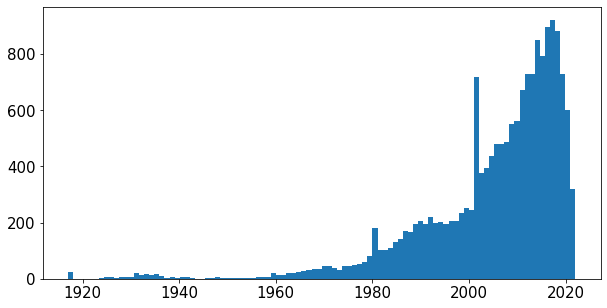

In [215]:
#Graph of number of anime released each year
anime_df_no_syn[anime_df_no_syn['Year_Premiered']!='Unknown'].Year_Premiered.hist(bins=100, figsize=(10,5), grid=False, xlabelsize=15, ylabelsize=15);

In [216]:
# Checking dataframe from pornographic titles, also known as Hentai
anime_df_no_syn[anime_df_no_syn['Genres'].str.contains('Hentai')]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered
165,188,Gosenzo San'e,6.11,"Comedy, Hentai, Mystery, Supernatural",Masquerade,御先祖賛江,OVA,4,"Sep 25, 1998 to Mar 25, 1999",Unknown,"AIC, Green Bunny, BEAM Entertainment",Unknown,Unknown,Original,30 min. per ep.,Rx - Hentai,Unknown,8469,2308,4,148,1072,100,122,866,51.0,42.0,89.0,168.0,159.0,132.0,59.0,19.0,20.0,33.0,Masquerade,1998
180,203,Words Worth,6.75,"Adventure, Hentai, Demons, Magic, Fantasy",Unknown,ワーズ・ワース,OVA,5,"Aug 25, 1999 to Nov 25, 2000",Unknown,Green Bunny,NuTech Digital,Arms,Visual novel,30 min. per ep.,Rx - Hentai,Unknown,5518,7447,38,391,4406,264,265,2121,211.0,291.0,606.0,871.0,577.0,331.0,149.0,69.0,51.0,40.0,Words Worth,1999
188,211,Pure Mail,6.26,Hentai,Unknown,ピュアメール,OVA,2,"Sep 25, 2001 to Dec 21, 2001",Unknown,"Pink Pineapple, Green Bunny",Adult Source Media,Unknown,Visual novel,30 min. per ep.,Rx - Hentai,Unknown,7731,3114,14,177,1834,112,122,869,64.0,71.0,165.0,268.0,310.0,175.0,86.0,43.0,25.0,26.0,Pure Mail,2001
190,213,Pia Carrot e Youkoso!!,6.02,"Comedy, Romance, Hentai",Welcome to Pia Carrot,Piaキャロットへようこそ!!,OVA,3,"Oct 24, 1997 to Apr 24, 1998",Unknown,NuTech Digital,Unknown,Unknown,Unknown,29 min. per ep.,Rx - Hentai,Unknown,7767,3074,5,156,1715,106,139,958,50.0,48.0,114.0,240.0,281.0,196.0,89.0,54.0,18.0,30.0,Welcome to Pia Carrot,1997
191,214,Pia Carrot e Youkoso!! 2,6.15,"Comedy, Romance, Hentai",Welcome To Pia Carrot 2,Piaキャロットへようこそ!! 2,OVA,3,"Oct 23, 1998 to Apr 23, 1999",Unknown,Pink Pineapple,Unknown,Unknown,Unknown,30 min. per ep.,Rx - Hentai,Unknown,8715,2097,4,99,1247,65,100,586,42.0,40.0,97.0,169.0,197.0,119.0,62.0,23.0,11.0,28.0,Welcome To Pia Carrot 2,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17358,44192,Kimi ga Suki. The Animation,6.83,Hentai,Unknown,君が好き. THE ANIMATION,OVA,2,"Jan 29, 2021 to Mar 26, 2021",Unknown,Pink Pineapple,Unknown,Seven,Manga,Unknown,Rx - Hentai,Unknown,8068,2745,16,1235,5,273,87,1145,85.0,78.0,139.0,221.0,165.0,71.0,26.0,22.0,11.0,16.0,Kimi ga Suki. The Animation,2021
17359,44193,Ano Ko no Kawari ni Suki na Dake,5.91,Hentai,Unknown,実娘[あの子]の代わりに好きなだけ,OVA,2,"Dec 18, 2020 to ?",Unknown,Unknown,Unknown,Unknown,Manga,20 min. per ep.,Rx - Hentai,Unknown,10274,1097,4,605,5,175,69,243,41.0,13.0,37.0,81.0,97.0,55.0,39.0,21.0,9.0,12.0,Ano Ko no Kawari ni Suki na Dake,2020
17360,44194,Haitoku no Kyoukai,6.18,Hentai,Unknown,背徳の境界,OVA,Unknown,"Jan 29, 2021 to ?",Unknown,Unknown,Unknown,Unknown,Original,Unknown,Rx - Hentai,Unknown,10039,1226,3,520,5,174,66,461,22.0,17.0,36.0,80.0,79.0,48.0,18.0,11.0,10.0,6.0,Haitoku no Kyoukai,2021
17366,44211,Rikujoubu Joshi wa Ore no Nama Onaho!!! The An...,Unknown,Hentai,Unknown,陸上部女子は俺の生オナホ!!! The Animation,OVA,2,"Feb 26, 2021 to Apr 30, 2021",Unknown,Unknown,Unknown,Unknown,Digital manga,20 min. per ep.,Rx - Hentai,Unknown,11168,755,5,122,0,52,21,560,6.0,3.0,5.0,11.0,16.0,8.0,9.0,3.0,1.0,1.0,Rikujoubu Joshi wa Ore no Nama Onaho!!! The An...,2021


In [217]:
#Dropping Hentai from dataframe
anime_df_no_syn.drop(anime_df_no_syn[anime_df_no_syn['Genres'].str.contains('Hentai')].index, inplace=True)

In [218]:
anime_df_no_syn.reset_index(drop=True, inplace=True)

### Creating Duration_in_minutes column

In [219]:
#Splitting str values in Duration
anime_df_no_syn['Duration'] = anime_df_no_syn['Duration'].str.split()

In [220]:
anime_df_no_syn['Duration'][1]

['1', 'hr.', '55', 'min.']

In [221]:
#With the values now as lists of strings, I created this list comprehension to convert hours, minutes, and seconds
#into minutes
anime_df_no_syn['Duration_in_Minutes'] = [anime_df_no_syn['Duration'][x][0] if len(anime_df_no_syn['Duration'][x]) <= 1
                                         else (int(anime_df_no_syn['Duration'][x][0])/60 if anime_df_no_syn['Duration'][x][1] == 'sec.' 
                                         else (int(anime_df_no_syn['Duration'][x][0]) if anime_df_no_syn['Duration'][x][1] == 'min.'
                                         else ((int(anime_df_no_syn['Duration'][x][0])*60) + int(anime_df_no_syn['Duration'][x][2]) if anime_df_no_syn['Duration'][x][1] == 'hr.' and len(anime_df_no_syn['Duration'][x]) >= 4 and anime_df_no_syn['Duration'][x][2] != 'per'
                                         else (int(anime_df_no_syn['Duration'][x][0])*60 if anime_df_no_syn['Duration'][x][1] == 'hr.' and len(anime_df_no_syn['Duration'][x]) == 2      
                                         else anime_df_no_syn['Duration'][x][0])))) for x in range(len(anime_df_no_syn['Duration']))]






In [222]:
#checking for any left over string values
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes'].apply(lambda x: isinstance(x, str))].Duration_in_Minutes.unique()

array(['1', 'Unknown'], dtype=object)

In [223]:
#Checking why '1' was missed 
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes']=='1'][['Duration', 'Duration_in_Minutes']]

,Duration,Duration_in_Minutes
1378,"[1, hr., per, ep.]",1
2839,"[1, hr., per, ep.]",1
4373,"[1, hr., per, ep.]",1
5553,"[1, hr., per, ep.]",1
8276,"[1, hr., per, ep.]",1


In [224]:
#Since it was only 5 values and all for the same reason, just used .replace to fix it
anime_df_no_syn['Duration_in_Minutes'].replace('1', 60, inplace=True)

In [225]:
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes'].apply(lambda x: isinstance(x, str))].Duration_in_Minutes.unique()

array(['Unknown'], dtype=object)

In [226]:
#Changing 'Unknown' values to NaN values to be able to more easily replace them
#with the mean of their respective Type
anime_df_no_syn['Duration_in_Minutes'].replace('Unknown', np.nan, inplace=True)

In [227]:
anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes

Type
Movie      53.130824
Music       3.346589
ONA         7.758006
OVA        29.058466
Special    18.666069
TV         19.547069
Unknown    23.000000
Name: Duration_in_Minutes, dtype: float64

In [228]:
anime_df_no_syn['Duration_in_Minutes'] = [anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Movie'] if anime_df_no_syn['Type'][x] =='Movie' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Music'] if anime_df_no_syn['Type'][x] =='Music' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['ONA'] if anime_df_no_syn['Type'][x] =='ONA' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['OVA'] if anime_df_no_syn['Type'][x] =='OVA' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Special'] if anime_df_no_syn['Type'][x] =='Special' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['TV'] if anime_df_no_syn['Type'][x] =='TV' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Unknown'] if anime_df_no_syn['Type'][x] =='Unknown' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else anime_df_no_syn['Duration_in_Minutes'][x])))))) for x in range(len(anime_df_no_syn['Duration_in_Minutes']))]



In [229]:
anime_df_no_syn['split_genres'] = anime_df_no_syn['Genres'].str.split(', ')

In [230]:
genre_list = []
for x in anime_df_no_syn['split_genres']:
    for value in x:
        if value not in genre_list:
            genre_list.append(value)
len(genre_list)  

42

In [231]:
genre_list = pd.DataFrame(genre_list, columns = ['genre'])


In [232]:
genre_list.to_csv('../Anime_rec_app/App_data/genre_list.csv')

### Dropping superfluous columns

In [233]:
columns_to_drop = anime_df_no_syn.drop(['MAL_ID', 'Cleaned_Name', 'Genres', 'Year_Premiered', 'Duration_in_Minutes', 'Type', 'Episodes', 'Rating', 'Popularity'], axis=1).columns
anime_df_no_syn.drop(columns_to_drop, axis=1, inplace=True )


In [234]:
anime_df_no_syn[anime_df_no_syn.duplicated(subset='Cleaned_Name', keep=False)].sort_values(['Cleaned_Name', 'Year_Premiered'])

,MAL_ID,Genres,Type,Episodes,Rating,Popularity,Cleaned_Name,Year_Premiered,Duration_in_Minutes
10534,32977,"Music, Slice of Life, Comedy",TV,100,PG-13 - Teens 13 or older,1778,Aggretsuko,2016,1.0
12735,36904,"Slice of Life, Comedy",ONA,10,PG-13 - Teens 13 or older,1256,Aggretsuko,2018,15.0
7790,22729,"Action, Military, Sci-Fi, Mecha",TV,12,R - 17+ (violence & profanity),299,Aldnoah.Zero,2014,23.0
8601,27655,"Action, Mecha, Sci-Fi, Space",TV,12,R - 17+ (violence & profanity),552,Aldnoah.Zero,2015,23.0
4755,8676,"Slice of Life, Comedy, Romance, School",TV,25,PG-13 - Teens 13 or older,487,Amagami SS,2010,24.0
...,...,...,...,...,...,...,...,...,...
14117,39143,Kids,OVA,1,G - All Ages,17368,Youkoso! Ecolo Shima,Unknown,17.0
14398,39540,Dementia,Movie,1,PG-13 - Teens 13 or older,16987,Zephyr,2009,6.0
8377,25833,"Music, Drama",Special,1,PG-13 - Teens 13 or older,8598,Zephyr,2014,26.0
2053,2404,"Action, Horror, Shounen, Supernatural",TV,11,R - 17+ (violence & profanity),1185,Zombie-Loan,2007,23.0


In [235]:
anime_df_no_syn['Cleaned_Name'] = [anime_df_no_syn['Cleaned_Name'][x]+' ('+str(anime_df_no_syn['Year_Premiered'][x])+')' 
                                    if anime_df_no_syn['Cleaned_Name'].duplicated(keep=False)[x]==True 
                                    else anime_df_no_syn['Cleaned_Name'][x] for x in range(len(anime_df_no_syn['Cleaned_Name']))]

In [236]:
anime_df_no_syn[anime_df_no_syn.duplicated(subset='Cleaned_Name', keep=False)].sort_values(['Cleaned_Name', 'Year_Premiered']).head(50)

,MAL_ID,Genres,Type,Episodes,Rating,Popularity,Cleaned_Name,Year_Premiered,Duration_in_Minutes
12725,36882,"Action, Adventure, Fantasy, Harem",TV,13,PG-13 - Teens 13 or older,383,Arifureta:From Commonplace to World's Stronges...,2019,23.000000
14679,40083,"Action, Adventure, Fantasy, Harem",Special,2,PG-13 - Teens 13 or older,2724,Arifureta:From Commonplace to World's Stronges...,2019,8.000000
14198,39230,"Slice of Life, Comedy",ONA,16,G - All Ages,15032,Beanie's Daily (2019),2019,3.000000
14753,40223,"Slice of Life, Comedy, Historical, Drama",ONA,3,G - All Ages,15700,Beanie's Daily (2019),2019,8.000000
10322,32595,"Adventure, Fantasy",TV,13,R - 17+ (violence & profanity),1593,Cerberus (2016),2016,24.000000
11522,34889,Music,Music,1,G - All Ages,13116,Cerberus (2016),2016,4.000000
2439,2903,"Action, Comedy, Martial Arts, School, Shounen",TV,34,R - 17+ (violence & profanity),4889,Charge!! Men's Private School (1988),1988,24.000000
3042,4031,"Action, Comedy, Martial Arts, School, Shounen",Movie,1,PG-13 - Teens 13 or older,8846,Charge!! Men's Private School (1988),1988,74.000000
11106,34088,"Action, Comedy, Historical",TV,12,G - All Ages,5728,Chiruran 1/2 (2017),2017,2.000000
11804,35301,"Action, Comedy, Historical",Special,1,G - All Ages,10852,Chiruran 1/2 (2017),2017,2.000000


In [237]:
anime_df_no_syn['Cleaned_Name'] = [anime_df_no_syn['Cleaned_Name'][x]+' ('+str(anime_df_no_syn['Type'][x])+')' 
                                    if anime_df_no_syn['Cleaned_Name'].duplicated(keep=False)[x]==True and anime_df_no_syn['Type'][x]!= 'TV'
                                    else anime_df_no_syn['Cleaned_Name'][x] for x in range(len(anime_df_no_syn['Cleaned_Name']))]

In [238]:
anime_df_no_syn[anime_df_no_syn.duplicated(subset='Cleaned_Name', keep=False)].sort_values('Cleaned_Name')


,MAL_ID,Genres,Type,Episodes,Rating,Popularity,Cleaned_Name,Year_Premiered,Duration_in_Minutes
14753,40223,"Slice of Life, Comedy, Historical, Drama",ONA,3,G - All Ages,15700,Beanie's Daily (2019) (ONA),2019,8.000000
14198,39230,"Slice of Life, Comedy",ONA,16,G - All Ages,15032,Beanie's Daily (2019) (ONA),2019,3.000000
15882,43207,Slice of Life,ONA,1,PG-13 - Teens 13 or older,15338,Dear My Patron (2020) (ONA),2020,16.000000
15786,42804,Slice of Life,ONA,Unknown,Unknown,13605,Dear My Patron (2020) (ONA),2020,7.758006
5423,10444,"Action, Adventure, Fantasy, Comedy, Shounen",TV,24,PG - Children,3490,Digimon Fusion (2011),2011,25.000000
5710,11385,"Action, Adventure, Comedy, Fantasy, Shounen",TV,25,PG - Children,3581,Digimon Fusion (2011),2011,25.000000
2047,2397,"Sci-Fi, Adventure, Comedy, Kids",Movie,1,PG - Children,1936,Digimon:The Movie (2000) (Movie),2000,41.000000
2475,2962,"Adventure, Fantasy, Kids, Sci-Fi",Movie,2,PG - Children,2552,Digimon:The Movie (2000) (Movie),2000,32.000000
15866,42985,"Action, Sci-Fi, Horror, Demons, Drama, Thriller",ONA,1,R - 17+ (violence & profanity),12676,Ling Cage (2019) (ONA),2019,46.000000
14470,39675,"Action, Sci-Fi, Horror, Demons, Drama, Thriller",ONA,6,R - 17+ (violence & profanity),8374,Ling Cage (2019) (ONA),2019,30.000000


In [239]:
anime_df_no_syn.drop_duplicates(subset='Cleaned_Name', keep='first', ignore_index=True, inplace=True)

In [240]:
anime_df_no_syn[anime_df_no_syn.duplicated(subset='Cleaned_Name', keep=False)].sort_values('Cleaned_Name')

,MAL_ID,Genres,Type,Episodes,Rating,Popularity,Cleaned_Name,Year_Premiered,Duration_in_Minutes


# Cleaning up user ratings

In [241]:
#Importing all user ratings into a dataframe
anime_user_ratings = pd.read_csv('./Anime_data/animelist.csv')

In [242]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [243]:
#Checking number of unique users
len(anime_user_ratings.user_id.unique())

325770

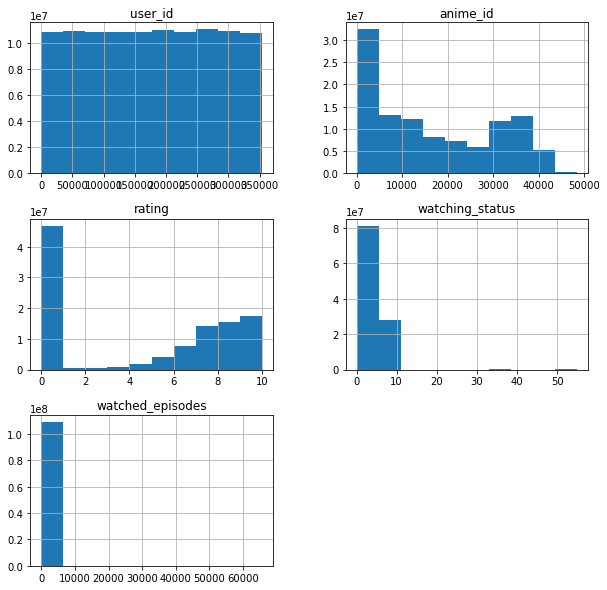

In [244]:
#checking to see if patterns exist in the distribution of the columns
anime_user_ratings.hist(figsize=(10,10));

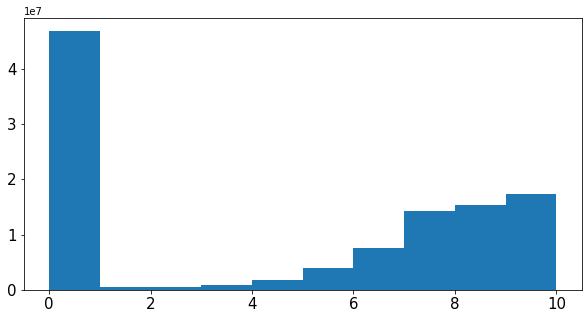

In [245]:
anime_user_ratings['rating'].hist(figsize=(10,5), grid=False, xlabelsize=15, ylabelsize=15);

In [246]:
anime_user_ratings.describe()

,user_id,anime_id,rating,watching_status,watched_episodes
count,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08
mean,1.768098e+05,1.649590e+04,4.245717e+00,3.087289e+00,1.210818e+01
std,1.018487e+05,1.379737e+04,3.912888e+00,1.774407e+00,1.463155e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.849100e+04,3.194000e+03,0.000000e+00,2.000000e+00,0.000000e+00
50%,1.771420e+05,1.244500e+04,5.000000e+00,2.000000e+00,3.000000e+00
75%,2.651870e+05,3.083100e+04,8.000000e+00,6.000000e+00,1.200000e+01
max,3.534040e+05,4.849200e+04,1.000000e+01,5.500000e+01,6.553500e+04


In [247]:
anime_user_ratings.watching_status.unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55])

In [248]:
#Ratings of zero denote that the user has not watched the show or didn't rate it so I decided the drop all rows
#where ratings equals zero since rating scale only goes from 1 -10
anime_user_ratings.rating.replace(0,np.nan, inplace=True)

In [249]:
anime_user_ratings.dropna(inplace=True)

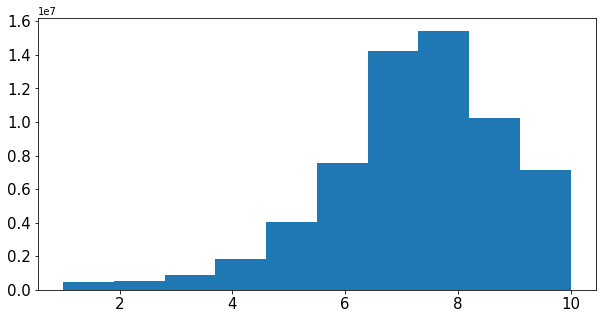

In [250]:
anime_user_ratings['rating'].hist(figsize=(10,5), grid=False, xlabelsize=15, ylabelsize=15);

In [251]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62397712 entries, 0 to 109224745
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   anime_id          int64  
 2   rating            float64
 3   watching_status   int64  
 4   watched_episodes  int64  
dtypes: float64(1), int64(4)
memory usage: 2.8 GB


In [252]:
anime_user_ratings.groupby('watching_status').size()

watching_status
0           77
1      1485402
2     57633278
3      1056358
4      1947440
5            1
6       275155
33           1
dtype: int64

In [253]:
anime_user_ratings[(anime_user_ratings['watching_status'] >= 5) & (anime_user_ratings['rating'] !=0) & (anime_user_ratings['watched_episodes']==0)]


,user_id,anime_id,rating,watching_status,watched_episodes
1060,3,38938,8.0,6,0
6210,19,851,8.0,6,0
6220,19,30484,9.0,6,0
7984,32,32867,8.0,6,0
8013,32,18153,5.0,6,0
...,...,...,...,...,...
109207088,353340,3503,9.0,6,0
109208914,353345,33253,10.0,6,0
109212929,353361,4713,10.0,6,0
109217083,353379,270,7.0,6,0


In [254]:
#Dropping rows where there was a rating for a show that user had not watched but is planning to watch
anime_user_ratings.drop(anime_user_ratings[(anime_user_ratings['watching_status'] >= 5) & (anime_user_ratings['rating'] !=0) & (anime_user_ratings['watched_episodes']==0)].index, inplace=True)



In [255]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62195089 entries, 0 to 109224745
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   anime_id          int64  
 2   rating            float64
 3   watching_status   int64  
 4   watched_episodes  int64  
dtypes: float64(1), int64(4)
memory usage: 2.8 GB


In [256]:
#creating a subset of only the top 1000 anime title by Popularity
Top_1000_anime = anime_df_no_syn[anime_df_no_syn['Popularity'] != 0].sort_values('Popularity', ascending=True).head(1000)



In [257]:
len(Top_1000_anime.MAL_ID)

1000

In [258]:
#Creating a subset of only the users which have rated a show in the top 1000 anime dataframe 
anime_id_1000_anime = anime_user_ratings[anime_user_ratings.anime_id.isin(list(Top_1000_anime.MAL_ID))][['user_id', 'anime_id', 'rating']]



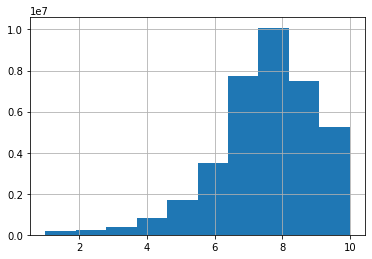

In [259]:
anime_id_1000_anime.rating.hist();

In [260]:
anime_id_1000_anime.groupby('user_id').size().sort_values()

user_id
60795       1
5690        1
20177       1
117532      1
262504      1
         ... 
291207    979
298783    983
298988    990
321704    990
283786    995
Length: 311213, dtype: int64

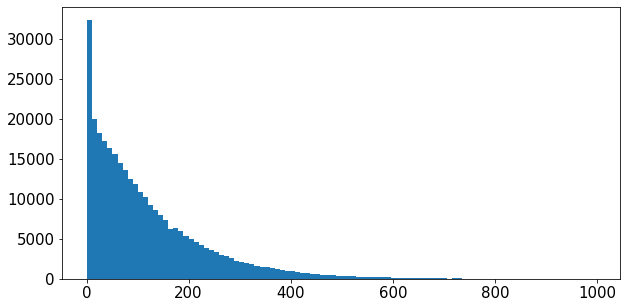

In [261]:
#graph showing the number of titles each user had rated
anime_id_1000_anime.groupby('user_id').size().sort_values().hist(bins=100, figsize=(10,5), grid=False, xlabelsize=15, ylabelsize=15);

In [262]:
anime_id_1000_anime.groupby('user_id').size().describe()

count    311213.000000
mean        120.122071
std         115.784683
min           1.000000
25%          35.000000
50%          86.000000
75%         170.000000
max         995.000000
dtype: float64

Created an smaller user subset consisting of users who had rated at least 5 shows but no more 
than 10. This was done to create the largest possible set of users that would be able to run given my hardware limitation. It should be noted though that the ratings distribution of the newly created subset is different from the ratings distribution of the entire set

In [263]:
filtered_df_1000_anime = anime_id_1000_anime.groupby('user_id').filter(lambda x : len(x)>=5)
filtered_df_1000_anime = filtered_df_1000_anime.groupby('user_id').filter(lambda x : len(x)<=10)

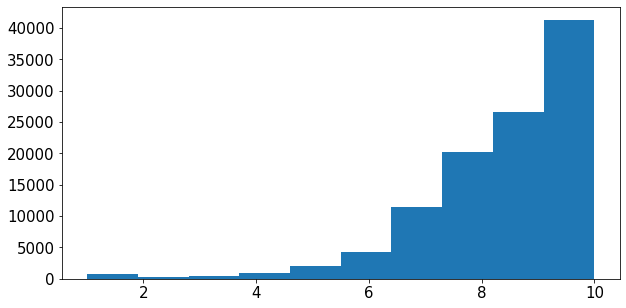

In [264]:
filtered_df_1000_anime.rating.hist(figsize=(10,5), grid=False, xlabelsize=15, ylabelsize=15);

In [265]:
len(filtered_df_1000_anime.user_id)

108219

In [266]:
len(filtered_df_1000_anime.anime_id.unique())

997

In [267]:
filtered_df_1000_anime.reset_index(drop=True, inplace=True)

In [268]:
Top_1000_anime.reset_index(drop=True, inplace=True)

In [269]:
Top_1000_anime.to_csv('../Anime_rec_app/App_data/Top_1000_anime.csv')

In [270]:
filtered_df_1000_anime.to_csv('../Anime_rec_app/App_data/filtered_user_ratings.csv')

In [271]:
anime_df_with_syn = pd.read_csv('./Anime_data/anime_with_synopsis.csv')

In [272]:
anime_df_with_syn.rename(columns={'sypnopsis':'synopsis'},inplace=True)

In [273]:
anime_syn_1000 = anime_df_with_syn[anime_df_with_syn.MAL_ID.isin(list(Top_1000_anime.MAL_ID))][['MAL_ID', 'synopsis']].reset_index(drop=True)

In [274]:
anime_syn_1000.to_csv('../Anime_rec_app/App_data/anime_syn_1000.csv')

# Modeling

## SVD Model with default parameters

In [56]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(filtered_df_1000_anime, reader)

In [57]:
train, test = train_test_split(data, test_size=.25)

In [57]:
svd_model = SVD()

In [58]:
%%time

svd_model.fit(train)
accuracy.rmse(svd_model.test(test))

RMSE: 1.5059
CPU times: user 4.62 s, sys: 31.9 ms, total: 4.65 s
Wall time: 4.64 s


1.5058921549679818

## Gridsearch with SVD model

In [59]:
params = {'n_factors': [50, 100, 200],
         'n_epochs': [20, 50, 100],
         'reg_all': [0.02, 0.001, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, cv=3, n_jobs=-1, joblib_verbose=5)
g_s_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  9.2min finished


In [60]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.503841959690847, 'mae': 1.141095400603579}
{'rmse': {'n_factors': 50, 'n_epochs': 100, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'n_epochs': 100, 'reg_all': 0.1}}


## SVD++ model with default parameters

In [61]:
svdpp_model = SVDpp()

In [62]:
svdpp_model.fit(train)
accuracy.rmse(svdpp_model.test(test))

RMSE: 1.5379


1.5378527537587983

## Gridsearch with SVD++

In [63]:
params = {'n_factors': [50, 100, 200],
         'n_epochs': [20, 50, 100],
         'reg_all': [0.02, 0.001, 0.1]}
g_s_svd = GridSearchCV(SVDpp, param_grid=params, cv=3, n_jobs=-1, joblib_verbose=5)
g_s_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 29.9min finished


In [64]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.5389974308130767, 'mae': 1.1697542059949604}
{'rmse': {'n_factors': 50, 'n_epochs': 20, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'reg_all': 0.1}}


While there is an improvement in both RMSE and MAE with the SVD++ model, the difference is  only in the thousandths and the time needed to complete is 7 times longer.

## KNN model with different K values

In [ ]:
knn_basic_rmse_list = []

# Calculate RMSE for different K
for k in range(15, 160, 15):
    knn_basic = KNNBasic(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_basic.fit(train)
    knn_basic_rmse_list.append(accuracy.rmse(knn_basic.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_basic_rmse_list)
ax.grid(True)

In [ ]:
knn_basic = KNNBasic(k=75, sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1, verbose=True)

In [ ]:
np.mean(cv_knn_basic['test_rmse'])

## KNN baseline model with different K values

In [ ]:
knn_baseline_rmse_list = []

# Calculate SSE for different K
for k in range(15, 160, 15):
    knn_baseline = KNNBaseline(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_baseline.fit(train)
    knn_baseline_rmse_list.append(accuracy.rmse(knn_baseline.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_baseline_rmse_list)
ax.grid(True)

In [ ]:
knn_baseline = KNNBaseline(k=75, sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs=-1, verbose=True)

In [ ]:
np.mean(cv_knn_baseline['test_rmse'])

## KNN with Means model with different K values

In [ ]:
knn_means_rmse_list = []

# Calculate RMSE for different K
for k in range(15, 160, 15):
    knn_means = KNNWithMeans(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_means.fit(train)
    knn_means_rmse_list.append(accuracy.rmse(knn_means.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_means_rmse_list)
ax.grid(True)

In [ ]:
knn_item_baseline = KNNBaseline(k=75, sim_options={'name':'pearson', 'user_based':False})
cv_knn_item_baseline = cross_validate(knn_item_baseline, data, n_jobs=-1, verbose=True)

In [ ]:
np.mean(cv_knn_item_baseline['test_rmse'])

# Creating a function

In the next few cells, I create and test functions which I will ultimately combine to create my recommender system

In [284]:
def Anime_rater(Top_1000_anime, num, genre=None):
    userID = 300000000
    rating_list = []
    while num > 0:
        if genre:
            anime = Top_1000_anime[Top_1000_anime['Genres'].str.contains(genre)].sample(1)
        else:
            anime = Top_1000_anime.sample(1)
        print(anime[['Cleaned_Name','Year_Premiered','Type']])
        rating = input('How do you rate this anime on a scale of 1-10, press n if you have not seen :\n')
        if rating not in str(list(range(1,11))):
            continue
        else:
            rating_one_anime = {'user_id':userID,'anime_id':anime['MAL_ID'].values[0],'rating':rating}
            rating_list.append(rating_one_anime) 
            num -= 1
    return rating_list    

In [286]:
user_rating = Anime_rater(Top_1000_anime, 6)

    Cleaned_Name Year_Premiered Type
107        K-ON!           2009   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
6
    Cleaned_Name Year_Premiered Type
690     Mononoke           2007   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
7
      Cleaned_Name Year_Premiered Type
856  Psycho-Pass 3           2019   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
6
         Cleaned_Name Year_Premiered Type
271  Eden of The East           2009   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
5
    Cleaned_Name Year_Premiered Type
395    MEGALOBOX           2018   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
4
                            Cleaned_Name Year_Premiered Type
663  The Comic Artist and His Assistants           2014   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
6


In [287]:
user_rating

[{'user_id': 300000000, 'anime_id': 5680, 'rating': '6'},
 {'user_id': 300000000, 'anime_id': 2246, 'rating': '7'},
 {'user_id': 300000000, 'anime_id': 39491, 'rating': '6'},
 {'user_id': 300000000, 'anime_id': 5630, 'rating': '5'},
 {'user_id': 300000000, 'anime_id': 36563, 'rating': '4'},
 {'user_id': 300000000, 'anime_id': 21863, 'rating': '6'}]

In [289]:
reader = Reader(rating_scale=(1,10))

In [290]:
new_ratings_df = filtered_df_1000_anime.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [291]:
svd_ = SVD(n_factors=200, reg_all=0.1, n_epochs=100)
svd_.fit(new_data.build_full_trainset())

In [292]:
list_of_anime = []
for m_id in filtered_df_1000_anime['anime_id'].unique():
    list_of_anime.append((m_id,svd_.predict(3000000000,m_id)[3]))

In [293]:
ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)

In [ ]:
def recommended_anime(user_ratings, anime_title_df, n):
        for idx, rec in enumerate(user_ratings):
            title = anime_title_df.loc[anime_title_df['MAL_ID'] == int(rec[0])]['Cleaned_Name']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_anime(ranked_anime, Top_1000_anime, 5)

[(0, (6675, 9.29162114995551)),
 (1, (25537, 9.290071246632472)),
 (2, (5205, 9.269878120265755)),
 (3, (34096, 9.265010707770688)),
 (4, (36649, 9.256151741652317)),
 (5, (9969, 9.238176137252328)),
 (6, (10012, 9.216797470204385)),
 (7, (486, 9.21602770670963)),
 (8, (329, 9.20327389465304)),
 (9, (11061, 9.19629082314617)),
 (10, (39533, 9.193656525158291)),
 (11, (4282, 9.190698393716858)),
 (12, (35839, 9.190693924177522)),
 (13, (30654, 9.185864182262991)),
 (14, (28851, 9.183612201779303)),
 (15, (19, 9.17503257098161)),
 (16, (19647, 9.172406231555904)),
 (17, (22135, 9.171584685000015)),
 (18, (9253, 9.169481037739114)),
 (19, (37055, 9.166346231370479)),
 (20, (28735, 9.160573413749555)),
 (21, (11665, 9.158631139497839)),
 (22, (31757, 9.157311160272727)),
 (23, (40052, 9.154084301093175)),
 (24, (34599, 9.152721515778767)),
 (25, (34612, 9.152332376208248)),
 (26, (31758, 9.151326378693867)),
 (27, (30484, 9.149952763753642)),
 (28, (35180, 9.143078675578836)),
 (29, (12355

# Recommender Function

In [ ]:
#This function takes in a user ratings dataframe, a dataframe of anime title, the number of 
#ratings the user wants to input, the number of recommendations the user wants back, whether
#or not the user is new, genre the user is looking for ie. 'Action', and the type of show
# ie. 'Movie', 'TV'

def Anime_Recommender_2(user_ratings, anime_df, rating_num, rec_num, new_user=True, genre=None, show_type=None):
    
    #In the block below, if the user = False, user is asked to input their userID. If the input is
    #not in the dataframe, the user will receive a message and will be asked to input again until
    #a user_id that in the datafram is entered
    
    user_entry = 1
    while user_entry > 0:
        if new_user == False:
            userID = int(input('Please enter User ID (Numerical values only)'))
            if userID not in list(user_ratings['user_id']) or userID == '':
                print('User ID not in system')
                continue
            else:
                print('Welcome Back')
                user_entry -= 1
                
    #if new_user = True, a userId will be created and diplayed
    
        else:
            userID = user_ratings['user_id'].max() + 1
            print('Welcome')
            print('Your User ID is: ',userID)
            user_entry -= 1
            
    #in the block below an empty dataframe is created and filled with input ratings for randomly 
    # selected shows from anime_df 
            
    rating_list = pd.DataFrame()
    if rating_num == 0 and new_user == True:
        while rating_num == 0:
            rating_num = int(input('Please input the number of ratings you would like to make'))
    elif rating_num == 0:
        rating_list = rating_list.append(user_ratings[user_ratings['user_id']==userID], ignore_index=True)
    while rating_num > 0:
        anime = anime_df.sample(1)
        print(anime[['Cleaned_Name','Year_Premiered','Type']])
        rating = input('How do you rate this anime on a scale of 1-10, press n if you have not seen :\n')
        if rating == 'n':
            clear_output(wait=True)        
        elif rating not in str(list(range(1,11))) or rating == '':           
            clear_output(wait=True)
            print('Not a valid entry') 
        else:
            rating_one_anime = {'user_id':userID,'anime_id':anime['MAL_ID'].values[0],'rating':rating}
            rating_list = rating_list.append(rating_one_anime, ignore_index=True)
            rating_list = rating_list[['user_id','anime_id','rating']]
            clear_output(wait=True)
            rating_num -= 1
            
    #in the block below the rating_list is appended to the user_rating dataframe, and fit to 
    #an SVD model with the best parameters from the gridsearch
            
    new_ratings_df = user_ratings.append(rating_list, ignore_index=True) 
    reader_rec = Reader(rating_scale=(1,10))
    new_data = Dataset.load_from_df(new_ratings_df, reader_rec)
    svd_ = SVD(n_factors=200, reg_all=0.1, n_epochs=100)
    svd_.fit(new_data.build_full_trainset())
    
    #in the block below the model predicts the rating for every unique anime in the user_ratings
    #dataframe. The prediction is appended to an empty list then sorted by predicted rating 

    
    list_of_anime = []
    for a_id in user_ratings['anime_id'].unique():
        list_of_anime.append((a_id, svd_.predict(userID, a_id)[3]))
    ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)
    
    #in the block below, a FOR loop removes anime that the user has already rated from the list
    
    new_ranked_anime = []
    for x in ranked_anime:
        if x[0] in list(rating_list['anime_id']):
            continue
        else:
            new_ranked_anime.append(x)
            
    #in the block below, if a genre is entered, a FOR loop removes all anime that is not 
    #part of the input genre
    
    if genre:
        new_list = []
        genre_list = list(anime_df[anime_df['Genres'].str.contains(genre)]['MAL_ID'])
        for x in new_ranked_anime:
            if x[0] in genre_list:
                new_list.append(x)
            else:
                continue
        new_ranked_anime = new_list
    else:
        pass
    
    #in the block below, if show_type is entered, a FOR loop removes all anime that is not 
    #part of the input show_type
    
    if show_type:
        new_list = []
        type_list = list(anime_df[anime_df['Type'].str.contains(show_type)]['MAL_ID'])
        for x in new_ranked_anime:
            if x[0] in type_list:
                new_list.append(x)
            else:
                continue
        new_ranked_anime = new_list
    else:
        pass
    
    #in the block below, new_ranked_anime is counted, if the list is empty, the user is informed,
    #if the list contains less results than asked, then a separate message is printed and all
    #available results are shown, otherwise, the asked for results are printed 
    
    if len(new_ranked_anime) == 0:
        return print('Unfortunately, no results fit your criteria')  
    elif len(new_ranked_anime) < rec_num:
        rec_num = len(new_ranked_anime)
        print('Sorry, These are all our results')   
    else:
        pass
    for idx, rec in enumerate(new_ranked_anime):
        title = anime_df.loc[anime_df['MAL_ID'] == int(rec[0])]['Cleaned_Name'].values[0]
        show_type = anime_df.loc[anime_df['MAL_ID'] == int(rec[0])]['Type'].values[0]
        if show_type == 'TV':
            show_type = 'This is a Series'
        elif show_type == 'Music':
            show_type = 'This is a Music Video'
        elif show_type == 'ONA':
            show_type = 'This is an ONA (Original Net Animation)'
        elif show_type == 'OVA':
            show_type = 'This is an OVA (Original Video Animation)'
        print(f' Recommendation # {idx+1}: {title}\n         {show_type}\n')
        rec_num -= 1
        if rec_num <= 0:
            break
            

In [305]:
Anime_Recommender_2(filtered_df_1000_anime, Top_1000_anime, 5, 5)

Recommendation # 1: Bloom Into You
         This is a Series

Recommendation # 2: Attack on Titan Season 3 Part 2
         This is a Series

Recommendation # 3: The Disastrous Life of Saiki K. 2
         This is a Series

Recommendation # 4: Given
         This is a Series

Recommendation # 5: Redline
         Movie



In the future, I hope to recreate this function by calling smaller functions within it, as in its current form, troubleshooting any changes can take a very long time.

<pre> HI!!               Hello!! </pre>